In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from attention_layer import AttentionLayer

In [4]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import nltk
nltk.download("stopwords")
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Science\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import pickle
x = pickle.load(open("x", "rb"))
y = pickle.load(open("y", "rb"))

In [12]:
data = pd.DataFrame(data={"Text":x, "Summary": y})

In [13]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [14]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [18]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [20]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [22]:
data.reset_index(drop=True, inplace=True)

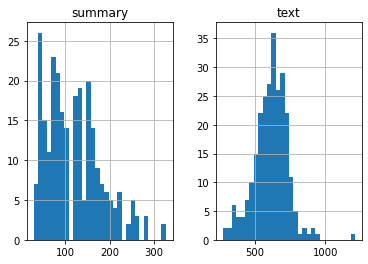

In [25]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

### Check how long the summary needs to be, so we lose less data

In [26]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=910):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9846743295019157


### Check the same for the text length

In [21]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=390):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

1.0


In [27]:
max_len_text=910
max_len_summary=390
embedding_dim = 20
latent_dim = 250

##### Define a batch size

In [28]:
batch_size = 4

In [29]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [30]:
from sklearn.model_selection import train_test_split
x_tr_str,x_val_str,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.001,random_state=0,shuffle=True)

In [31]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=10000)
x_tokenizer.fit_on_texts(list(x_tr_str))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr_str) 
x_val   =   x_tokenizer.texts_to_sequences(x_val_str)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [32]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer(num_words=10000)
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

### Delete empty summaries

In [33]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

print(f"Length of rows was: {len(x_tr)}")
y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)
print(f"Length of rows is: {len(x_tr)}")

Length of rows was: 260
Length of rows is: 260


In [34]:
from tensorflow.keras import backend as K 
K.clear_session() 

# Encoder 
encoder_inputs = Input(batch_input_shape=(None, max_len_text,)) 
enc_emb = Embedding(x_voc_size, embedding_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(batch_input_shape=(None, None,)) 
dec_emb_layer = Embedding(y_voc_size, embedding_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 910)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 910, 20)      186100      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 910, 250), ( 271000      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [35]:
import pydot_ng

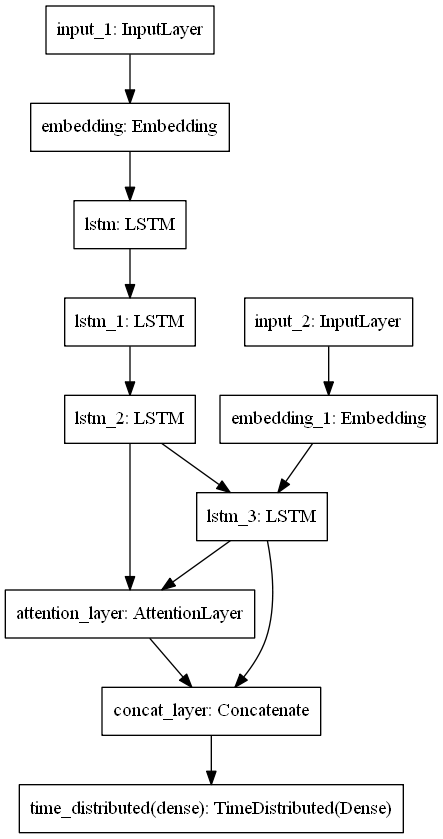

In [36]:
tf.keras.utils.plot_model(model)

In [37]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [38]:
es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.002, verbose=1)

In [39]:
def text_to_sequence(text):
    text_tokenized = x_tokenizer.texts_to_sequences([text])
    #padding zero upto maximum length
    text_padded = pad_sequences(text_tokenized, maxlen=max_len_text, padding='post')
    return text_padded

def reverse_seq(seq):
    out_seq = [seq[i] for i in range(len(seq) -1, -1, -1)]
    return seq

def prepareDataSetTrain(x_tr, y_tr):
    amount_x_tr_cuddn_fix = len(x_tr)-(len(x_tr) % batch_size)
    x_tr = x_tr[:amount_x_tr_cuddn_fix]
    x_tr = [reverse_seq(review_int) for review_int in [l for l in x_tr]]
    y_tr = y_tr[:amount_x_tr_cuddn_fix]
    print(len(x_tr) % batch_size)
    print(len(y_tr) % batch_size)
    dataset_x_input = tf.data.Dataset.from_tensor_slices(x_tr)
    dataset_x_context = tf.data.Dataset.from_tensor_slices(y_tr[:,:-1])
    dataset_y = tf.data.Dataset.from_tensor_slices(y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:])
    dataset_x = tf.data.Dataset.from_tensor_slices(x_tr)
    dataset_train = tf.data.Dataset.zip((dataset_x_input, dataset_x_context))
    dataset_train = tf.data.Dataset.zip((dataset_train, dataset_y))
    dataset_train_batched = dataset_train.batch(batch_size)
    return dataset_train_batched

def prepareDataPredict(sentence):
    sentence = text_cleaner(sentence)
    sentence = summary_cleaner(sentence)
    print(sentence)
    texts = []
    text_padded = text_to_sequence(sentence)
    texts.append(tf.convert_to_tensor(text_padded[0]))
    data_out = tf.convert_to_tensor(texts)
    return data_out

In [40]:
dataset_train_batched = prepareDataSetTrain(x_tr, y_tr)

0
0


In [41]:
val_per = 0.1
len_ds = 0
# Count the items in the dataset
for i in dataset_train_batched:
    len_ds = len_ds+1

# This code is based on a fix by user jliebers so the amount of sequences % batch_size = 0  
# The last batch might not be full, so it will be discarded through casted into integer
max_len_ds = len_ds
len_split = int(max_len_ds * val_per)
train_amount = max_len_ds - len_split
len_split = len_split -1

In [42]:
history=model.fit(dataset_train_batched.take(train_amount), epochs=10,callbacks=[es], batch_size=batch_size, validation_data=dataset_train_batched.skip(train_amount).take(len_split))

Epoch 1/10
 1/59 [..............................] - ETA: 0s - loss: 8.0331 - accuracy: 0.0000e+00

InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 20, 250, 1, 910, 4, 250] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[PartitionedCall_3]] [Op:__inference_train_function_13679]

Function call stack:
train_function -> train_function -> train_function
